In [62]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
import torch.nn.functional as F

In [45]:
# Hyper Parameters
EPOCH = 20
BATCH_SIZE = 64
LR = 0.005         # learning rate
DOWNLOAD_MNIST = False
N_TEST_IMG = 5
MAX_UNITS = 512
HIDDEN_DIM = 512

torch.Size([60000, 28, 28])
torch.Size([60000])


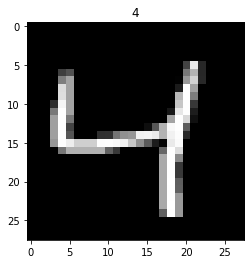

In [46]:
# Mnist digits dataset
train_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=True,                                     # this is training data
    transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,                        # download it if you don't have it
)

# plot one example
print(train_data.train_data.size())     # (60000, 28, 28)
print(train_data.train_labels.size())   # (60000)
plt.imshow(train_data.train_data[2].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[2])
plt.show()

In [47]:
# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

In [48]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, MAX_UNITS//2),
            nn.ReLU(),
            nn.Linear(MAX_UNITS//2, MAX_UNITS//4),
            nn.ReLU(),
            nn.Linear(MAX_UNITS//4, MAX_UNITS//4),
            nn.ReLU(),
            nn.Linear(MAX_UNITS//4, HIDDEN_DIM),   # compress to HIDDEN_DIM features which can be visualized in plt
        )
        self.decoder = nn.Sequential(
            nn.Linear(HIDDEN_DIM, MAX_UNITS//4),
            nn.ReLU(),
            nn.Linear(MAX_UNITS//4, MAX_UNITS//4),
            nn.ReLU(),
            nn.Linear(MAX_UNITS//4, MAX_UNITS//2),
            nn.ReLU(),
            nn.Linear(MAX_UNITS//2, 28*28),
            nn.Sigmoid(),       # compress to a range (0, 1)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [49]:
autoencoder = AutoEncoder()

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
loss_func = nn.MSELoss()

Epoch:  0 | train loss: 0.0297


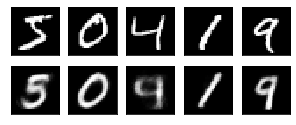

Epoch:  1 | train loss: 0.0239


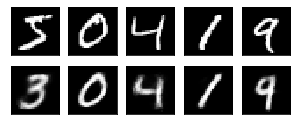

Epoch:  2 | train loss: 0.0229


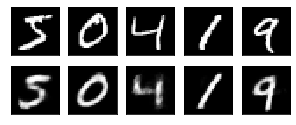

Epoch:  3 | train loss: 0.0206


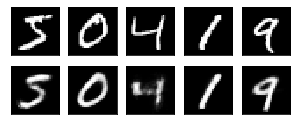

Epoch:  4 | train loss: 0.0176


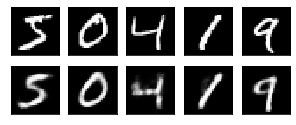

Epoch:  5 | train loss: 0.0210


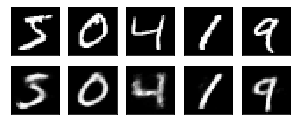

Epoch:  6 | train loss: 0.0181


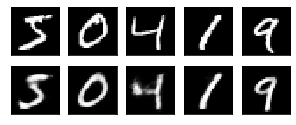

Epoch:  7 | train loss: 0.0174


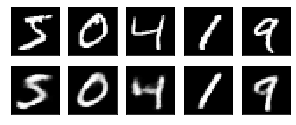

Epoch:  8 | train loss: 0.0219


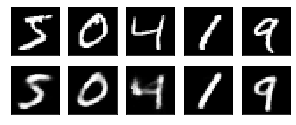

Epoch:  9 | train loss: 0.0141


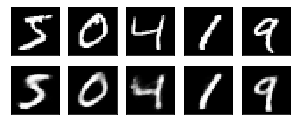

Epoch:  10 | train loss: 0.0143


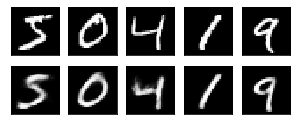

Epoch:  11 | train loss: 0.0164


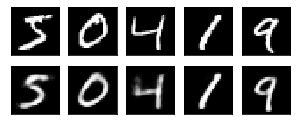

Epoch:  12 | train loss: 0.0140


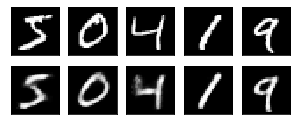

Epoch:  13 | train loss: 0.0155


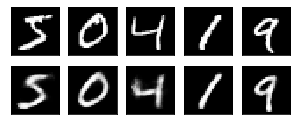

Epoch:  14 | train loss: 0.0147


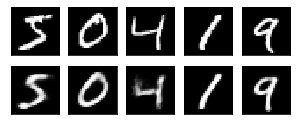

Epoch:  15 | train loss: 0.0174


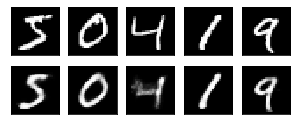

Epoch:  16 | train loss: 0.0151


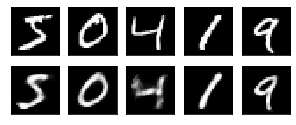

Epoch:  17 | train loss: 0.0150


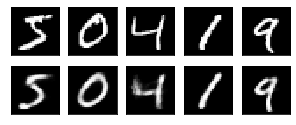

Epoch:  18 | train loss: 0.0148


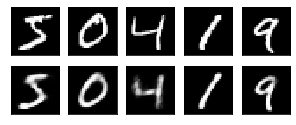

Epoch:  19 | train loss: 0.0129


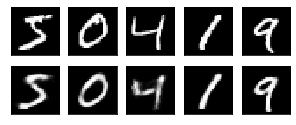

In [50]:
# initialize figure

# original data (first row) for viewing
view_data = train_data.train_data[:N_TEST_IMG].view(-1, 28*28).type(torch.FloatTensor)/255.

for epoch in range(EPOCH):
    for step, (x, b_label) in enumerate(train_loader):
        b_x = x.view(-1, 28*28)   # batch x, shape (batch, 28*28)
        b_y = x.view(-1, 28*28)   # batch y, shape (batch, 28*28)

        encoded, decoded = autoencoder(b_x)

        loss = loss_func(decoded, b_y)      # mean square error
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients

    print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy())

    # plotting decoded image (second row)
    _, decoded_data = autoencoder(view_data)
    f, a = plt.subplots(2, N_TEST_IMG, figsize=(5, 2))
    for i in range(N_TEST_IMG):
        a[0][i].imshow(np.reshape(view_data.data.numpy()[i], (28, 28)), cmap='gray'); a[0][i].set_xticks(()); a[0][i].set_yticks(())
                
        a[1][i].clear()
        a[1][i].imshow(np.reshape(decoded_data.data.numpy()[i], (28, 28)), cmap='gray')
        a[1][i].set_xticks(()); a[1][i].set_yticks(())
    plt.draw()
    plt.show()

plt.ioff()
plt.show()

In [ ]:
# visualize in 3D plot
view_data = train_data.train_data[:200].view(-1, 28*28).type(torch.FloatTensor)/255.
encoded_data, _ = autoencoder(view_data)
fig = plt.figure(2); ax = Axes3D(fig)
X, Y, Z = encoded_data.data[:, 0].numpy(), encoded_data.data[:, 1].numpy(), encoded_data.data[:, 2].numpy()
values = train_data.train_labels[:200].numpy()
for x, y, z, s in zip(X, Y, Z, values):
    c = cm.rainbow(int(255*s/9)); ax.text(x, y, z, s, backgroundcolor=c)
ax.set_xlim(X.min(), X.max()); ax.set_ylim(Y.min(), Y.max()); ax.set_zlim(Z.min(), Z.max())
plt.show()

In [52]:
list(autoencoder.children())

[Sequential(
   (0): Linear(in_features=784, out_features=256, bias=True)
   (1): ReLU()
   (2): Linear(in_features=256, out_features=128, bias=True)
   (3): ReLU()
   (4): Linear(in_features=128, out_features=128, bias=True)
   (5): ReLU()
   (6): Linear(in_features=128, out_features=512, bias=True)
 ), Sequential(
   (0): Linear(in_features=512, out_features=128, bias=True)
   (1): ReLU()
   (2): Linear(in_features=128, out_features=128, bias=True)
   (3): ReLU()
   (4): Linear(in_features=128, out_features=256, bias=True)
   (5): ReLU()
   (6): Linear(in_features=256, out_features=784, bias=True)
   (7): Sigmoid()
 )]

### Sparse Autoencoders
From https://debuggercafe.com/sparse-autoencoders-using-l1-regularization-with-pytorch/

In [58]:
# get the layers as a list
model_children = list(autoencoder.children())

In [59]:
# define the sparse loss function
def sparse_loss(autoencoder, images):
    loss = 0
    values = images
    for i in range(len(model_children)):
        values = F.relu((model_children[i](values)))
        loss += torch.mean(torch.abs(values))
    return loss

In [60]:
autoencoder = AutoEncoder()

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
loss_func = nn.MSELoss()

Epoch:  0 | train loss: 0.0272 mse_loss: 0.021933535113930702


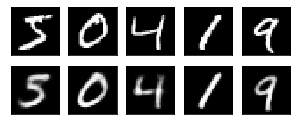

Epoch:  1 | train loss: 0.0240 mse_loss: 0.018742673099040985


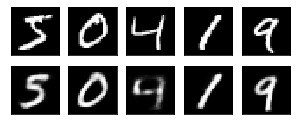

Epoch:  2 | train loss: 0.0216 mse_loss: 0.016338758170604706


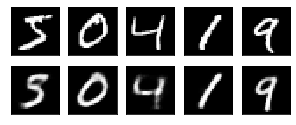

Epoch:  3 | train loss: 0.0214 mse_loss: 0.01611313968896866


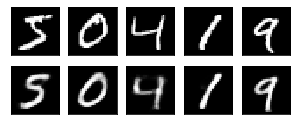

Epoch:  4 | train loss: 0.0243 mse_loss: 0.019070954993367195


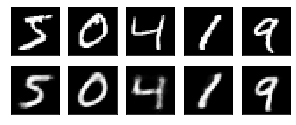

Epoch:  5 | train loss: 0.0228 mse_loss: 0.01755720190703869


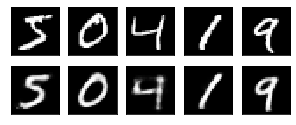

Epoch:  6 | train loss: 0.0211 mse_loss: 0.015812620520591736


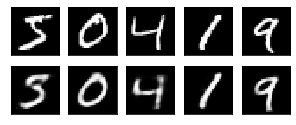

Epoch:  7 | train loss: 0.0206 mse_loss: 0.015313895419239998


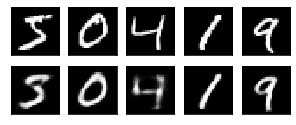

Epoch:  8 | train loss: 0.0221 mse_loss: 0.016891924664378166


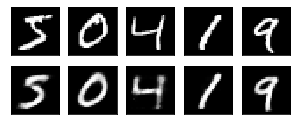

Epoch:  9 | train loss: 0.0213 mse_loss: 0.016094962134957314


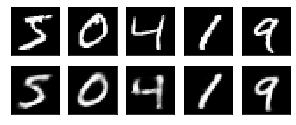

In [66]:
# Hyperparams
reg_param = 0.01
EPOCH = 10
add_sparsity = "yes"

# original data (first row) for viewing
view_data = train_data.train_data[:N_TEST_IMG].view(-1, 28*28).type(torch.FloatTensor)/255.

for epoch in range(EPOCH):
    for step, (x, b_label) in enumerate(train_loader):
        b_x = x.view(-1, 28*28)   # batch x, shape (batch, 28*28)
        b_y = x.view(-1, 28*28)   # batch y, shape (batch, 28*28)

        encoded, decoded = autoencoder(b_x)

        mse_loss = loss_func(decoded, b_y)      # mean square error
        
        if add_sparsity == 'yes':
            l1_loss = sparse_loss(autoencoder, b_x)
            # add the sparsity penalty
            loss = mse_loss + reg_param * l1_loss
        else:
            loss = mse_loss
        
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients

    print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy(), 'mse_loss: {}'.format(mse_loss))

    # plotting decoded image (second row)
    _, decoded_data = autoencoder(view_data)
    f, a = plt.subplots(2, N_TEST_IMG, figsize=(5, 2))
    for i in range(N_TEST_IMG):
        a[0][i].imshow(np.reshape(view_data.data.numpy()[i], (28, 28)), cmap='gray'); a[0][i].set_xticks(()); a[0][i].set_yticks(())
                
        a[1][i].clear()
        a[1][i].imshow(np.reshape(decoded_data.data.numpy()[i], (28, 28)), cmap='gray')
        a[1][i].set_xticks(()); a[1][i].set_yticks(())
    plt.draw()
    plt.show()

plt.ioff()
plt.show()